In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd/content/drive/MyDrive/glasses

/content/drive/MyDrive/glasses


In [3]:
import sys
import numpy as np
import cv2


In [4]:
# 3채널 img 영상에 4채널 item 영상을 pos 위치에 합성
def overlay(img, glasses, pos):
    # 실제 합성을 수행할 부분 영상 좌표 계산
    sx = pos[0]
    ex = pos[0] + glasses.shape[1]
    sy = pos[1]
    ey = pos[1] + glasses.shape[0]

    # 합성할 영역이 입력 영상 크기를 벗어나면 무시
    if sx < 0 or sy < 0 or ex > img.shape[1] or ey > img.shape[0]:
        return

    # 부분 영상 참조. img1: 입력 영상의 부분 영상, img2: 안경 영상의 부분 영상
    img1 = img[sy:ey, sx:ex]   # shape=(h, w, 3)
    img2 = glasses[:, :, 0:3]  # shape=(h, w, 3)
    alpha = 1. - (glasses[:, :, 3] / 255.)  # shape=(h, w)

    # BGR 채널별로 두 부분 영상의 가중합
    img1[..., 0] = (img1[..., 0] * alpha + img2[..., 0] * (1. - alpha)).astype(np.uint8)
    img1[..., 1] = (img1[..., 1] * alpha + img2[..., 1] * (1. - alpha)).astype(np.uint8)
    img1[..., 2] = (img1[..., 2] * alpha + img2[..., 2] * (1. - alpha)).astype(np.uint8)

In [5]:
# Haar-like XML 파일 열기
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
eye_classifier = cv2.CascadeClassifier('haarcascade_eye.xml')

if face_classifier.empty() or eye_classifier.empty():
    print('XML load failed!')
    sys.exit()

In [6]:
# 안경 PNG 파일 열기 (Image from http://www.pngall.com/)
glasses = cv2.imread('/content/drive/MyDrive/glasses/test2.png', cv2.IMREAD_UNCHANGED)

if glasses is None:
    print('PNG image open failed!')
    sys.exit()

ew, eh = glasses.shape[:2]  # 가로, 세로 크기
ex1, ey1 = 315, 155  # 왼쪽 눈 좌표
ex2, ey2 = 825, 155  # 오른쪽 눈 좌표

In [7]:
glasses.shape

(500, 1200, 4)

In [8]:
glasses[0][:5]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

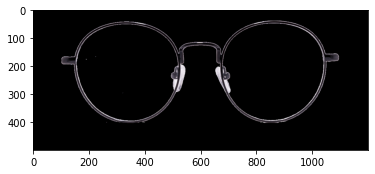

In [9]:
import matplotlib.pyplot as plt
imgRGB = cv2.cvtColor(glasses, cv2.COLOR_BGR2RGB)
#plt.axis('off') # 창에있는 x축 y축 제거
plt.imshow(imgRGB)
plt.show()

In [22]:
frame = cv2.imread("/content/drive/MyDrive/glasses/tom.jpg")

In [23]:
# 얼굴 검출
faces = face_classifier.detectMultiScale(frame, scaleFactor=1.2,
                                            minSize=(100, 100), maxSize=(400, 400))

In [24]:

for (x, y, w, h) in faces:
    #cv2.rectangle(frame, (x, y, w, h), (255, 0, 255), 2)

    # 눈 검출
    faceROI = frame[y:y + h // 2, x:x + w]
    eyes = eye_classifier.detectMultiScale(faceROI)

    # 눈을 2개 검출한 것이 아니라면 무시
    if len(eyes) != 2:
        continue

    # 두 개의 눈 중앙 위치를 (x1, y1), (x2, y2) 좌표로 저장
    x1 = x + eyes[0][0] + (eyes[0][2] // 2)
    y1 = y + eyes[0][1] + (eyes[0][3] // 2)
    x2 = x + eyes[1][0] + (eyes[1][2] // 2)
    y2 = y + eyes[1][1] + (eyes[1][3] // 2)

    if x1 > x2:
        x1, y1, x2, y2 = x2, y2, x1, y1

    #cv2.circle(faceROI, (x1, y1), 5, (255, 0, 0), 2, cv2.LINE_AA)
    #cv2.circle(faceROI, (x2, y2), 5, (255, 0, 0), 2, cv2.LINE_AA)

    # 두 눈 사이의 거리를 이용하여 스케일링 팩터를 계산 (두 눈이 수평하다고 가정)
    fx = (x2 - x1) / (ex2 - ex1)
    glasses2 = cv2.resize(glasses, (0, 0), fx=fx, fy=fx, interpolation=cv2.INTER_AREA)

    # 크기 조절된 안경 영상을 합성할 위치 계산 (좌상단 좌표)
    pos = (x1 - int(ex1 * fx), y1 - int(ey1 * fx))

    # 영상 합성
    overlay(frame, glasses2, pos)

In [25]:
from google.colab.patches import cv2_imshow

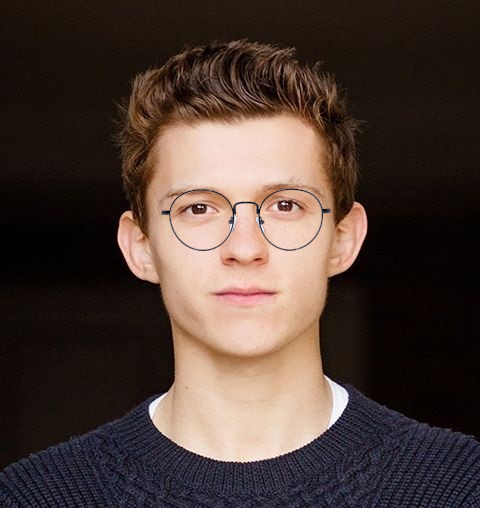

In [26]:
#out.write(frame)
cv2_imshow(frame)

In [16]:
type(frame)

numpy.ndarray